## SETUP PACKAGE

In [569]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## LOAD DATASET

In [570]:
df = pd.read_csv("churn.csv")

### Datasets Columns :
```
1. CustomerID = Contains unique values from every customer
2. Gender = Male and Female
3. SeniorCitizen = 1 for yes and 0 for no
4. Partner = Whether the customer has a partner (1) or no (0)
5. Dependents = Whether the customer has dependents or not (Yes, No)
6. tenure = Number of months the customer has stayed with the company
7. Contract = The contract term of the customer (Month-to-month, One year, Two year)
8. PaperlessBilling = Whether the customer has paperless billing or not (Yes, No)
9. PaymentMethod = The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
10. MonthlyCharges = The amount charged to the customer monthly
11. TotalCharges = The total amount charged to the customer
12. Churn = Whether the customer churned or not (Yes or No)
```

In [571]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7046 entries, 0 to 7045
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7037 non-null   object 
 1   Gender            7030 non-null   object 
 2   SeniorCitizen     7034 non-null   float64
 3   Partner           7030 non-null   object 
 4   Dependents        7027 non-null   object 
 5   Tenure            7029 non-null   float64
 6   Contract          7033 non-null   object 
 7   PaperlessBilling  7033 non-null   object 
 8   PaymentMethod     7035 non-null   object 
 9   MonthlyCharges    7036 non-null   float64
 10  TotalCharges      7046 non-null   float64
 11  Churn             7046 non-null   object 
dtypes: float64(4), object(8)
memory usage: 660.7+ KB


## DATA CLEANING

### Missing Values

In [572]:
df.isnull().sum()/len(df)*100

customerID          0.127732
Gender              0.227079
SeniorCitizen       0.170309
Partner             0.227079
Dependents          0.269657
Tenure              0.241272
Contract            0.184502
PaperlessBilling    0.184502
PaymentMethod       0.156117
MonthlyCharges      0.141924
TotalCharges        0.000000
Churn               0.000000
dtype: float64

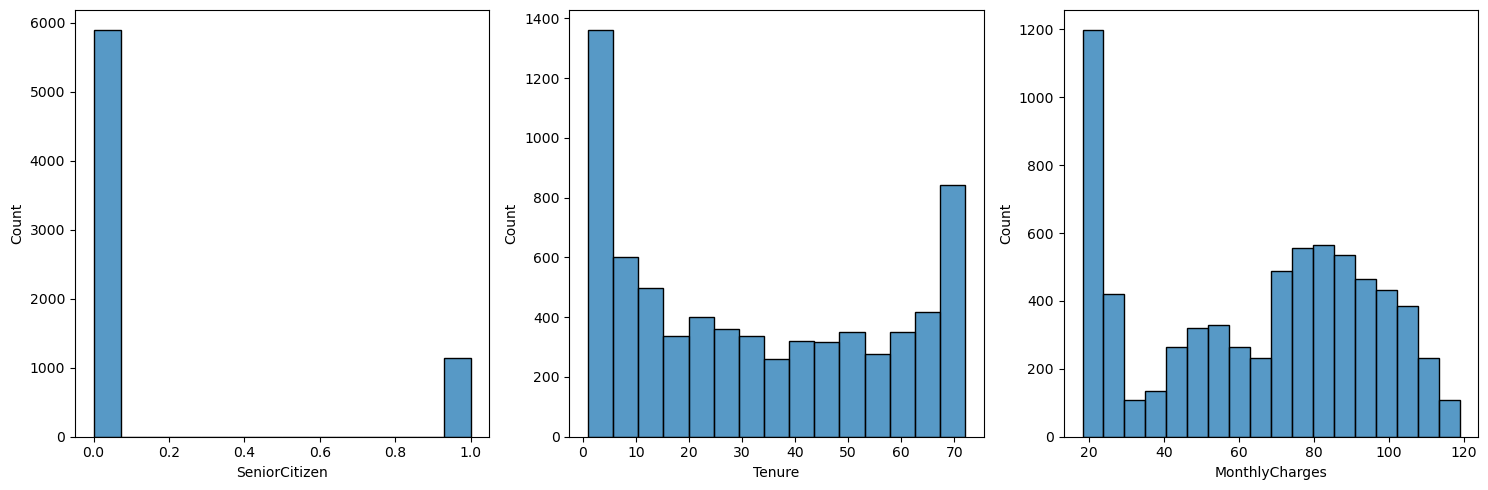

In [573]:
fig,ax = plt.subplots(1,3, figsize = (15,5))


sns.histplot(df, x = df["SeniorCitizen"], ax=ax[0])
sns.histplot(df, x = df["Tenure"], ax=ax[1])
sns.histplot(df, x = df["MonthlyCharges"], ax=ax[2])

plt.tight_layout()
plt.show()

Karena missing dibawah 5%, bias dipertimbangkan untuk hapus. Namun kita akan isi saja
- Kita akan lakukan drop untuk missing pada customer ID
- Menggunakan Modus untuk mengisi Categorical Column = Gender, Partner, Dependent, Payment Method
- Median untuk MonthlyCharged karena bukan normal distribution

In [574]:
# Drop customerID
df.dropna(subset="customerID", inplace=True)

In [575]:
# Impute with Mode
from sklearn.impute import SimpleImputer

imputer_mode = SimpleImputer(strategy='most_frequent')
df[['Gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']] = imputer_mode.fit_transform(df[['Gender', 'Partner', 'Dependents', 'Contract', 'PaperlessBilling', 'PaymentMethod']])

In [576]:
# Impute with Median

imputer_median = SimpleImputer(strategy='median')
df[['SeniorCitizen', 'Tenure', 'MonthlyCharges']] = imputer_median.fit_transform(df[['SeniorCitizen', 'Tenure', 'MonthlyCharges']])

In [577]:
df.isnull().sum()/len(df)*100

customerID          0.0
Gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
Tenure              0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

### Duplicated

In [578]:
df.duplicated().sum()

14

In [579]:
df = df.drop_duplicates()

In [580]:
df = df.drop("customerID", axis=1)

## DATA SPLIT

In [581]:
# as always, first thing is to split the data
from sklearn.model_selection import train_test_split

X = df.drop(columns='Churn')
y = df[['Churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

we don't need validation set, coz we use gridcv

### Encoding

We gonna do one hot-encoding to Contract and Payment Method before splitting

In [582]:
X_train_cat = X_train.select_dtypes(exclude=["number"]) 

In [583]:
# List of columns that need encoding (categorical variables)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

categorical_columns = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling']

# Initialize label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    X_train[col] = le.fit_transform(X_train[col])

In [584]:
categorical_columns = ['Gender', 'Partner', 'Dependents', 'PaperlessBilling']

# Initialize label encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_columns:
    X_test[col] = le.fit_transform(X_test[col])

In [585]:
X_train_numerik = X_train.select_dtypes(include=["number"]) 

In [586]:
y_train["Churn"] = le.fit_transform(y_train["Churn"])
y_test["Churn"] = le.fit_transform(y_test["Churn"])

In [587]:
# One Hot Encoding 
PaymentHot = pd.get_dummies(X_train['PaymentMethod'],prefix='PM')
ContractHot = pd.get_dummies(X_train['Contract'],prefix='contract')
PaymentHot = PaymentHot.astype(int)
ContractHot = ContractHot.astype(int)

In [588]:
X_train = pd.concat([X_train, ContractHot, PaymentHot], axis=1)
X_train.drop('Contract', axis=1, inplace=True)
X_train.drop('PaymentMethod', axis=1, inplace=True)
X_train.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,TotalCharges,contract_Month-to-month,contract_One year,contract_Two year,PM_Bank transfer (automatic),PM_Credit card (automatic),PM_Electronic check,PM_Mailed check
3275,1,0.0,1,0,55.0,0,58.60,3068.60,0,0,1,0,0,1,0
5277,1,0.0,1,0,8.0,1,74.50,609.90,1,0,0,0,0,1,0
1324,0,0.0,1,0,23.0,0,54.25,1221.55,1,0,0,0,0,1,0
7028,0,0.0,1,1,72.0,1,103.20,7362.90,0,1,0,0,1,0,0
4078,0,0.0,0,0,30.0,1,40.35,1187.05,0,1,0,0,1,0,0


In [589]:
# One Hot Encoding 
PaymentHot = pd.get_dummies(X_test['PaymentMethod'],prefix='PM')
ContractHot = pd.get_dummies(X_test['Contract'],prefix='contract')
PaymentHot = PaymentHot.astype(int)
ContractHot = ContractHot.astype(int)

In [590]:
X_test = pd.concat([X_test, ContractHot, PaymentHot], axis=1)
X_test.drop('Contract', axis=1, inplace=True)
X_test.drop('PaymentMethod', axis=1, inplace=True)
X_test.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,TotalCharges,contract_Month-to-month,contract_One year,contract_Two year,PM_Bank transfer (automatic),PM_Credit card (automatic),PM_Electronic check,PM_Mailed check
3916,1,0.0,0,0,1.0,1,80.85,80.85,1,0,0,0,0,0,1
2466,0,0.0,1,0,53.0,1,98.40,5149.50,1,0,0,0,1,0,0
2885,0,1.0,1,1,47.0,0,70.55,3309.25,1,0,0,1,0,0,0
5229,0,0.0,1,0,33.0,1,53.75,1857.30,0,1,0,0,1,0,0
6904,0,0.0,1,0,72.0,1,97.85,6841.30,0,0,1,0,0,1,0


## MULTICOLLINEARITY CHECK

In [591]:
X_train_numerik

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,TotalCharges
3275,1,0.0,1,0,55.0,0,58.60,3068.60
5277,1,0.0,1,0,8.0,1,74.50,609.90
1324,0,0.0,1,0,23.0,0,54.25,1221.55
7028,0,0.0,1,1,72.0,1,103.20,7362.90
4078,0,0.0,0,0,30.0,1,40.35,1187.05
...,...,...,...,...,...,...,...,...
3778,1,1.0,0,0,35.0,1,101.40,3496.30
5199,0,1.0,1,0,24.0,1,40.65,933.30
5234,1,0.0,0,0,19.0,1,87.70,1725.95
5399,0,0.0,0,0,51.0,0,24.95,1288.00


In [592]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
from statsmodels.tools.tools import add_constant

X = add_constant(X_train_numerik)

vif_df = pd.DataFrame([vif(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

,feature,vif_score
1,Gender,1.000579
2,SeniorCitizen,1.117259
3,Partner,1.461470
4,Dependents,1.369767
5,Tenure,5.999876
6,PaperlessBilling,1.172603
7,MonthlyCharges,3.423724
8,TotalCharges,9.446528


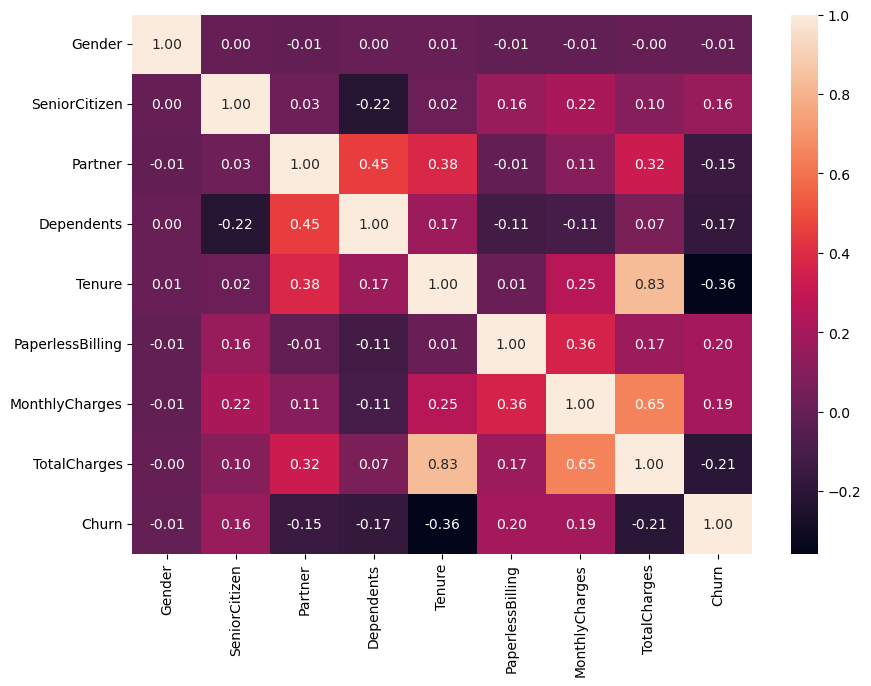

In [593]:
# heatmap correlation
X = pd.concat([X_train_numerik, y_train], axis=1)
corr = X.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

kita akan lakukan drop terhadap TotalCharges karena memiliki korelasi tinggi dengan `Tenure` dan `MonthlyCharges`

In [594]:
X_train = X_train.drop("TotalCharges", axis=1)
X_test = X_test.drop("TotalCharges", axis=1)

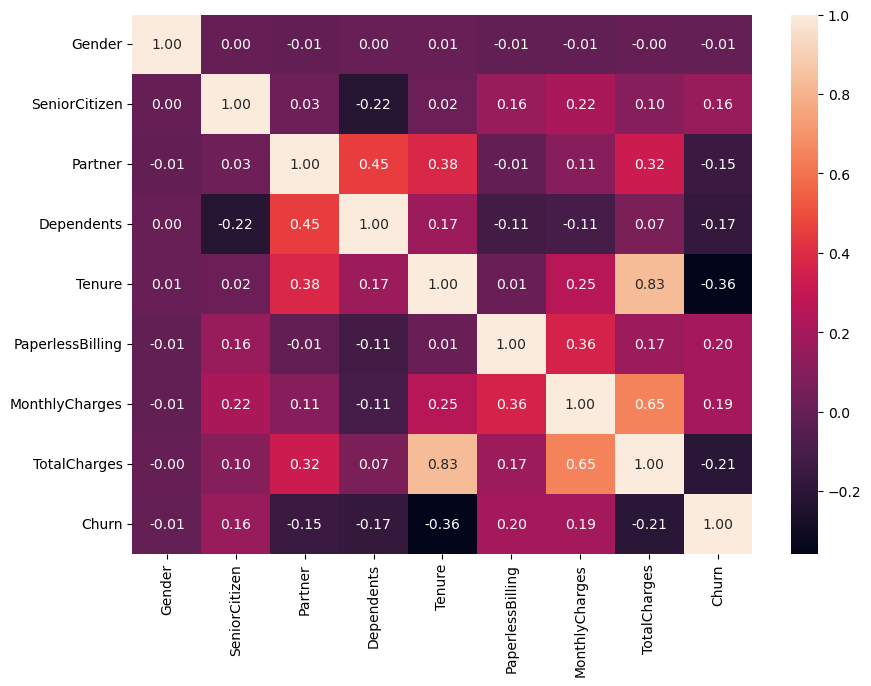

In [595]:
# heatmap correlation
X = pd.concat([X_train_numerik, y_train], axis=1)
corr = X.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

Good Enough

## EDA

In [596]:
X_train_cat.describe()

,Gender,Partner,Dependents,Contract,PaperlessBilling,PaymentMethod
count,5618,5618,5618,5618,5618,5618
unique,2,2,2,3,2,4
top,Male,No,No,Month-to-month,Yes,Electronic check
freq,2836,2921,3956,3095,3316,1899


## HANDLING OUTLIERS

In [597]:
features = list(X_train_numerik)

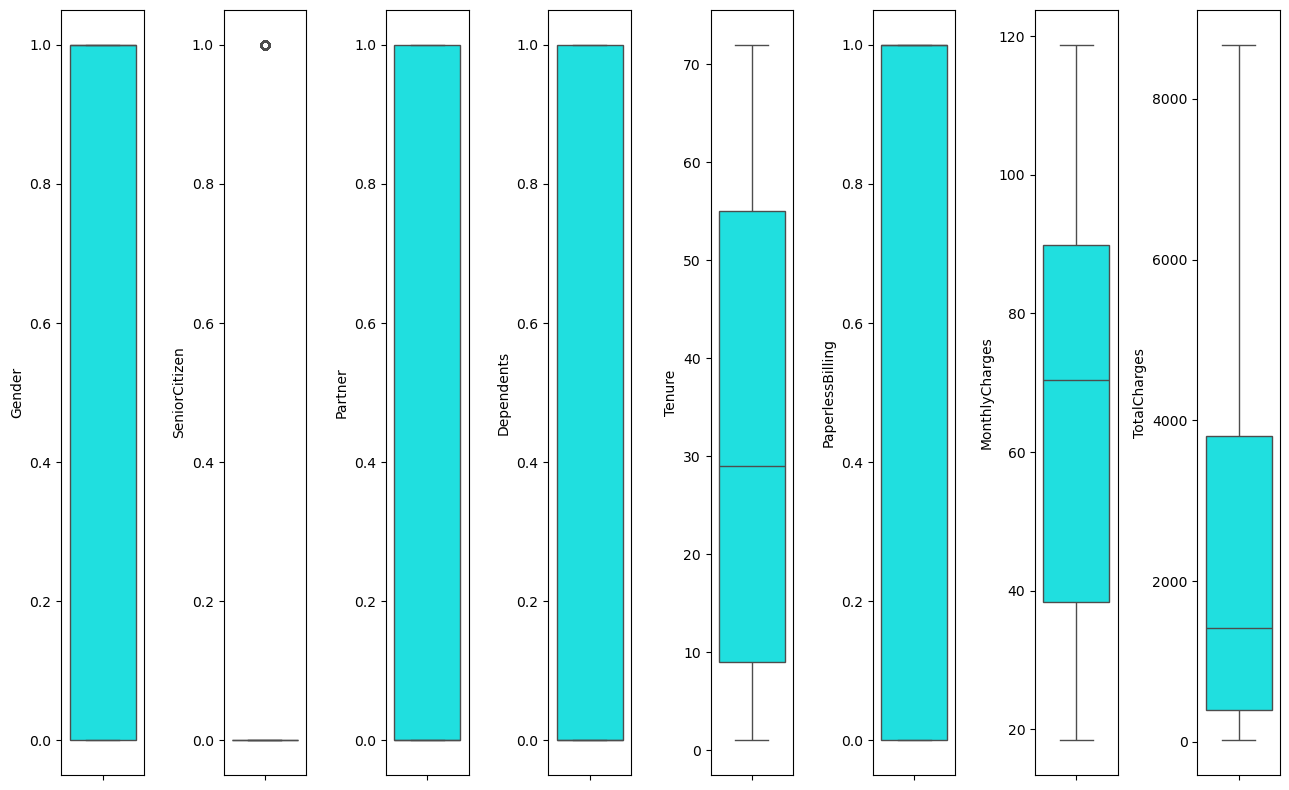

In [598]:
# Checking Outliers
plt.figure(figsize=(13, 8))
for i in range(0, len(features)):
    plt.subplot(1, 8, i+1)
    sns.boxplot(y=X_train_numerik[features[i]],color='cyan')
    plt.tight_layout()
plt.show()

No Outliers

### Data Scaling

In [599]:
stadardization = StandardScaler().fit_transform(X_train)
X_train_scaled = pd.DataFrame(stadardization, columns=list(X_train))
X_train_scaled.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PaperlessBilling,MonthlyCharges,contract_Month-to-month,contract_One year,contract_Two year,PM_Bank transfer (automatic),PM_Credit card (automatic),PM_Electronic check,PM_Mailed check
0,0.990434,-0.441949,1.040699,-0.648168,0.922960,-1.200203,-0.214852,-1.107571,-0.512043,1.772870,-0.531647,-0.523376,1.399428,-0.541277
1,0.990434,-0.441949,1.040699,-0.648168,-0.994413,0.833193,0.316506,0.902876,-0.512043,-0.564057,-0.531647,-0.523376,1.399428,-0.541277
2,-1.009659,-0.441949,1.040699,-0.648168,-0.382486,-1.200203,-0.360224,0.902876,-0.512043,-0.564057,-0.531647,-0.523376,1.399428,-0.541277
3,-1.009659,-0.441949,1.040699,1.542811,1.616478,0.833193,1.275624,-1.107571,1.952960,-0.564057,-0.531647,1.910671,-0.714578,-0.541277
4,-1.009659,-0.441949,-0.960892,-0.648168,-0.096919,0.833193,-0.824744,-1.107571,1.952960,-0.564057,-0.531647,1.910671,-0.714578,-0.541277


In [600]:
stadardization = StandardScaler().fit_transform(X_test)
X_test_scaled = pd.DataFrame(stadardization, columns=list(X_test))

## RIDGE REGRESSION

### Metrics Selection

In [601]:
# define ridge regression model
from sklearn.linear_model import Ridge

ridge_reg = Ridge(random_state=42)

In [602]:
# tune lambda (denote as 'alpha' in sklearn)
# using GridSearchCV
from sklearn.model_selection import GridSearchCV

# hyperparameter values we want to tune
parameters = {
    'alpha': (0.1, 1, 10, 20, 30, 40, 50,100)
}

# the tuning
ridge_reg_gridcv = GridSearchCV(ridge_reg, parameters, cv=5, 
                                scoring='neg_root_mean_squared_error')
ridge_reg_gridcv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Ridge(random_state=42),
             param_grid={'alpha': (0.1, 1, 10, 20, 30, 40, 50, 100)},
             scoring='neg_root_mean_squared_error')

In [603]:
pd.DataFrame(ridge_reg_gridcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006262,0.006126,0.004676,0.004754,0.1,{'alpha': 0.1},-0.385385,-0.372168,-0.380176,-0.383311,-0.385242,-0.381256,0.004917,7
1,0.005092,0.001716,0.002792,0.000413,1,{'alpha': 1},-0.385383,-0.372168,-0.380179,-0.383310,-0.385242,-0.381256,0.004917,6
2,0.005271,0.000771,0.003033,0.000695,10,{'alpha': 10},-0.385369,-0.372165,-0.380201,-0.383304,-0.385234,-0.381255,0.004913,5
3,0.005466,0.005979,0.000180,0.000360,20,{'alpha': 20},-0.385354,-0.372161,-0.380227,-0.383299,-0.385227,-0.381254,0.004909,3
4,0.007888,0.008417,0.000864,0.001062,30,{'alpha': 30},-0.385340,-0.372159,-0.380253,-0.383294,-0.385221,-0.381253,0.004905,1
5,0.003979,0.005030,0.004571,0.005329,40,{'alpha': 40},-0.385326,-0.372158,-0.380279,-0.383289,-0.385215,-0.381253,0.004901,2
6,0.007779,0.006445,0.002228,0.001947,50,{'alpha': 50},-0.385313,-0.372157,-0.380305,-0.383286,-0.385210,-0.381254,0.004897,4
7,0.006219,0.003891,0.003145,0.001697,100,{'alpha': 100},-0.385259,-0.372163,-0.380439,-0.383277,-0.385198,-0.381267,0.004878,8


In [604]:
# only show the most important columns
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(ridge_reg_gridcv.cv_results_)
cv_result[retain_cols]

,params,mean_test_score,rank_test_score
0,{'alpha': 0.1},-0.381256,7
1,{'alpha': 1},-0.381256,6
2,{'alpha': 10},-0.381255,5
3,{'alpha': 20},-0.381254,3
4,{'alpha': 30},-0.381253,1
5,{'alpha': 40},-0.381253,2
6,{'alpha': 50},-0.381254,4
7,{'alpha': 100},-0.381267,8


In [605]:
ridge_reg_gridcv.best_estimator_

Ridge(alpha=30, random_state=42)

In [606]:
intercept = ridge_reg_gridcv.best_estimator_.intercept_
coef = ridge_reg_gridcv.best_estimator_.coef_[0]

In [607]:
# show as a nice dataframe
coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train_scaled.columns.tolist(),
    'coefficient':[intercept] + list(coef)
})

coef_df

,feature,coefficient
0,intercept,[0.2673549305802777]
1,Gender,-0.000289
2,SeniorCitizen,0.027785
3,Partner,0.00009
4,Dependents,-0.013943
5,Tenure,-0.133884
6,PaperlessBilling,0.031288
7,MonthlyCharges,0.080076
8,contract_Month-to-month,0.033537
9,contract_One year,-0.027216


### Evaluation

In [608]:
from sklearn.metrics import r2_score

y_predict_train = ridge_reg_gridcv.best_estimator_.predict(X_train_scaled)

print('R-squared for training data is {}'.format(r2_score(y_train, y_predict_train)))

R-squared for training data is 0.2614511946801261


In [609]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, y_predict_train)))

RMSE for training data is 0.38034745488284166
MAE for training data is 0.3126958550845497
MAPE for training data is 756012818969845.5


In [610]:
y_predict_test = ridge_reg_gridcv.best_estimator_.predict(X_test_scaled)

print('R-squared for training data is {}'.format(r2_score(y_test, y_predict_test)))

R-squared for training data is 0.22723639009020724


In [611]:
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_test, y_predict_test))))
print('MAE for training data is {}'.format(mean_absolute_error(y_test, y_predict_test)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_test, y_predict_test)))

RMSE for training data is 0.3851439353340677
MAE for training data is 0.3162796050462389
MAPE for training data is 784236426276921.8


## LASSO REGRESSION

In [612]:
# the same thing, but we use Lasso
from sklearn.linear_model import Lasso

# somehow need to enlarge max_iter values
lasso_reg = Lasso(max_iter=10000, random_state=42)

In [613]:
# tune lambda (denote as 'alpha' in sklearn)
# using GridSearchCV
from sklearn.model_selection import GridSearchCV

# hyperparameter values we want to tune
parameters = {
    'alpha': (0.001, 0.01, 0.1, 1, 10,100)
}

# the tuning
lasso_reg_gridcv = GridSearchCV(lasso_reg, parameters, cv=5, 
                                scoring='neg_root_mean_squared_error')
lasso_reg_gridcv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=42),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 10, 100)},
             scoring='neg_root_mean_squared_error')

In [614]:
# only show the most important columns
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(lasso_reg_gridcv.cv_results_)
cv_result[retain_cols]

,params,mean_test_score,rank_test_score
0,{'alpha': 0.001},-0.381195,1
1,{'alpha': 0.01},-0.381700,2
2,{'alpha': 0.1},-0.414400,3
3,{'alpha': 1},-0.442607,4
4,{'alpha': 10},-0.442607,4
5,{'alpha': 100},-0.442607,4


In [615]:
lasso_reg_gridcv.best_estimator_

Lasso(alpha=0.001, max_iter=10000, random_state=42)

In [616]:
intercept = lasso_reg_gridcv.best_estimator_.intercept_
coef = lasso_reg_gridcv.best_estimator_.coef_

In [617]:
# show as a nice dataframe
coef_df = pd.DataFrame({
    'feature':['intercept'] + X_train.columns.tolist(),
    'coefficient':[intercept] + list(coef)
})

coef_df

,feature,coefficient
0,intercept,[0.2673549305802777]
1,Gender,-0.0
2,SeniorCitizen,0.027299
3,Partner,-0.0
4,Dependents,-0.013273
5,Tenure,-0.133578
6,PaperlessBilling,0.030774
7,MonthlyCharges,0.080106
8,contract_Month-to-month,0.049033
9,contract_One year,-0.013955


In [618]:
y_predict_train = lasso_reg_gridcv.best_estimator_.predict(X_train_scaled)

print('R-squared for training data is {}'.format(r2_score(y_train, y_predict_train)))

R-squared for training data is 0.2614236359587847


In [619]:
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_train, y_predict_train))))
print('MAE for training data is {}'.format(mean_absolute_error(y_train, y_predict_train)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_train, y_predict_train)))

RMSE for training data is 0.38035455109074706
MAE for training data is 0.3128409367720718
MAPE for training data is 755515345796828.1


In [620]:
y_predict_test = ridge_reg_gridcv.best_estimator_.predict(X_test_scaled)

print('R-squared for training data is {}'.format(r2_score(y_test, y_predict_test)))

R-squared for training data is 0.22723639009020724


In [621]:
print('RMSE for training data is {}'.format(np.sqrt(mean_squared_error(y_test, y_predict_test))))
print('MAE for training data is {}'.format(mean_absolute_error(y_test, y_predict_test)))
print('MAPE for training data is {}'.format(mean_absolute_percentage_error(y_test, y_predict_test)))

RMSE for training data is 0.3851439353340677
MAE for training data is 0.3162796050462389
MAPE for training data is 784236426276921.8


Looks like the model is underfitting, so we need a better model

## LOGISTIC REGRESSION

In [622]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [623]:
# Inisialisasi model Logistic Regression
log_reg = LogisticRegression()

# grid hyperparameter
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 200, 300]
}

log_reg_gridcv = GridSearchCV(estimator=log_reg, param_grid=param_grid, 
                           scoring='recall', cv=5, n_jobs=-1, verbose=1)
log_reg_gridcv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 200, 300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'saga']},
             scoring='recall', verbose=1)

In [624]:
# only show the most important columns
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result = pd.DataFrame(log_reg_gridcv.cv_results_)
cv_result[retain_cols].sort_values(by='rank_test_score', ascending=True)

,params,mean_test_score,rank_test_score
99,"{'C': 100, 'max_iter': 100, 'penalty': 'l2', '...",0.513291,1
74,"{'C': 10, 'max_iter': 100, 'penalty': 'l2', 's...",0.513291,1
105,"{'C': 100, 'max_iter': 200, 'penalty': 'l1', '...",0.513291,1
106,"{'C': 100, 'max_iter': 200, 'penalty': 'l2', '...",0.513291,1
107,"{'C': 100, 'max_iter': 200, 'penalty': 'l2', '...",0.513291,1
...,...,...,...
45,"{'C': 0.1, 'max_iter': 300, 'penalty': 'elasti...",NaN,46
44,"{'C': 0.1, 'max_iter': 300, 'penalty': 'elasti...",NaN,46
40,"{'C': 0.1, 'max_iter': 300, 'penalty': 'l1', '...",NaN,46
55,"{'C': 1, 'max_iter': 100, 'penalty': 'none', '...",NaN,46


In [625]:
log_reg_gridcv.best_estimator_

LogisticRegression(C=10)

In [626]:
# Menggunakan model terbaik untuk prediksi
best_model = log_reg_gridcv.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluasi
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7729537366548043
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      1041
           1       0.58      0.46      0.51       364

    accuracy                           0.77      1405
   macro avg       0.70      0.67      0.68      1405
weighted avg       0.76      0.77      0.76      1405



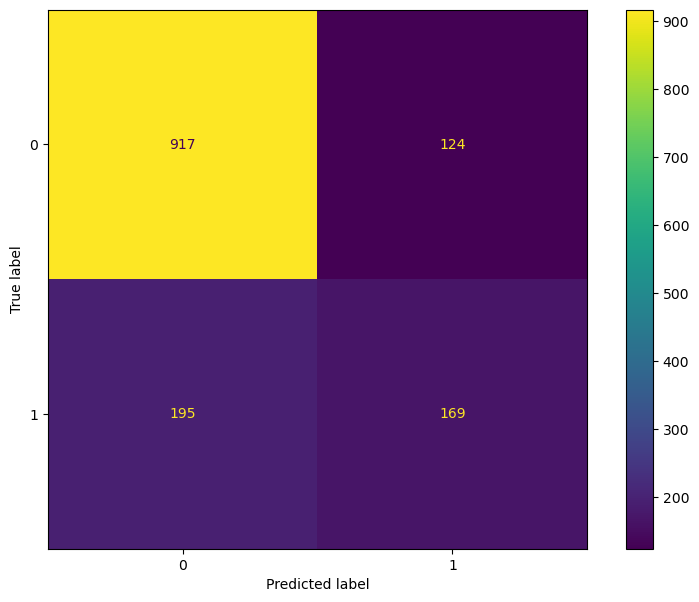

In [627]:
# plotting confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10,7))
y_pred = log_reg_gridcv.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=log_reg_gridcv.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=log_reg_gridcv.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

Angka False Negatives masih sangat tinggi, lebih tinggi dari True Positive!
Sangat fatal untuk dilakukan predict pelanggan churn

## DECISION TREE

In [628]:
from sklearn.tree import DecisionTreeClassifier

# Inisialisasi model Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Tentukan parameter grid untuk tuning
param_grid = {
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi GridSearchCV dengan cross-validation (cv=5)
clf_grid = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)

# Fit model dengan data training
clf_grid.fit(X_train_scaled, y_train)

# Tampilkan parameter terbaik
print("Best Parameters:", clf_grid.best_params_)
print("Best Score:", clf_grid.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Best Score: 0.5253178294573644


In [629]:
# Menggunakan model terbaik untuk prediksi
best_model = clf_grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# Evaluasi
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.7516014234875444
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84      1041
           1       0.52      0.47      0.49       364

    accuracy                           0.75      1405
   macro avg       0.67      0.66      0.66      1405
weighted avg       0.74      0.75      0.75      1405



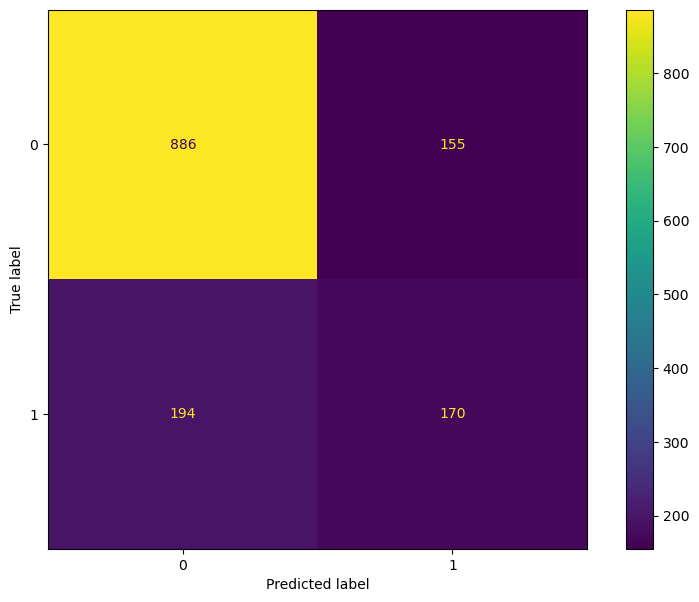

In [630]:
fig, ax = plt.subplots(figsize=(10,7))
y_pred = clf_grid.best_estimator_.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred, labels=clf_grid.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf_grid.best_estimator_.classes_)
disp.plot(ax=ax)
plt.show()

## Conclusion

The best model so far is Decision Tree, with the lowest False Negatives. Maybe We can get more explanation about churn by doing EDA only.